# AI Task Analysis and Predictive Modeling

**Project Goal:** The objective of this project is to conduct a thorough analysis of the `AI_DATA.csv` dataset. We aim to uncover underlying patterns in AI-related tasks, group them into meaningful categories using machine learning, and build a model that can automatically classify new tasks. The entire process and its findings are documented in this interactive notebook.

## Phase 1: Data Understanding and Exploratory Data Analysis (EDA)

The first step in any data analysis project is to understand the data we are working with. This involves loading the data, examining its basic properties, and looking for any immediate issues like missing values.

### 1.1. Initial Data Inspection

We will load the `AI_DATA.csv` file into a pandas DataFrame. We'll then use `df.head()` to see the first few rows, `df.info()` to get a summary of the data types and non-null values, `df.isnull().sum()` to check for missing data, and `df.describe()` to get descriptive statistics for the numerical columns.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv('AI_DATA.csv')

print('First 5 rows of the dataset:')
print(df.head())

print('Dataset Info:')
df.info()

print('Missing Values:')
print(df.isnull().sum())

print('Descriptive Statistics:')
print(df.describe())

First 5 rows of the dataset:
   Unnamed: 0                                          task_name  \
0           0  accept commissions to create music for special...   
1           1          act as advisers to student organizations.   
2           2  act as an advocate for farmers or farmers' gro...   
3           3  act as an intermediary in negotiations between...   
4           4  act as an intermediary in negotiations between...   

   feedback_loop  directive  task_iteration  validation  learning  filtered  
0            0.0   0.000000        0.000000         0.0       0.0  1.000000  
1            0.0   0.382979        0.361702         0.0       0.0  0.255319  
2            0.0   0.000000        0.000000         0.0       0.0  1.000000  
3            0.0   0.391304        0.434783         0.0       0.0  0.173913  
4            0.0   0.391304        0.376812         0.0       0.0  0.231884  
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data c

### 1.2. Visualizing Data Distributions

Histograms are a great way to visualize the distribution of each numerical feature. This helps us understand the range, central tendency, and shape of the data for each variable.

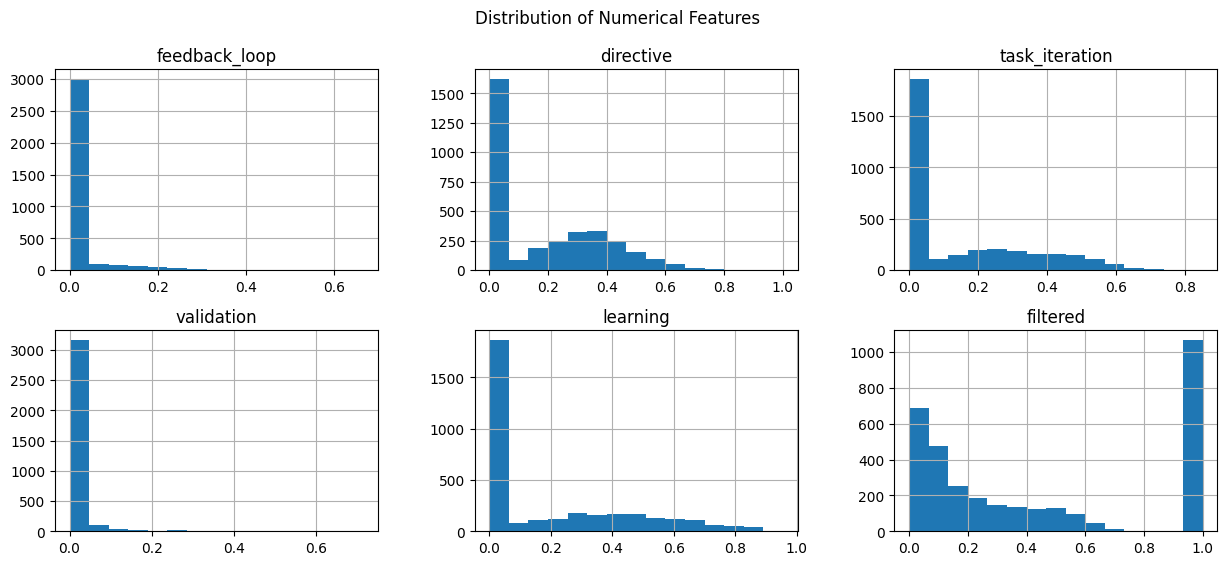

In [3]:
# EDA Visualizations
numerical_features = ['feedback_loop', 'directive', 'task_iteration', 'validation', 'learning', 'filtered']
df[numerical_features].hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features')
plt.show()

### 1.3. Correlation Analysis

A correlation matrix, visualized as a heatmap, helps us understand the relationships between numerical variables. A high positive correlation (close to 1) means that two variables tend to increase together, while a high negative correlation (close to -1) means one tends to increase as the other decreases. This is crucial for feature selection and understanding multicollinearity.

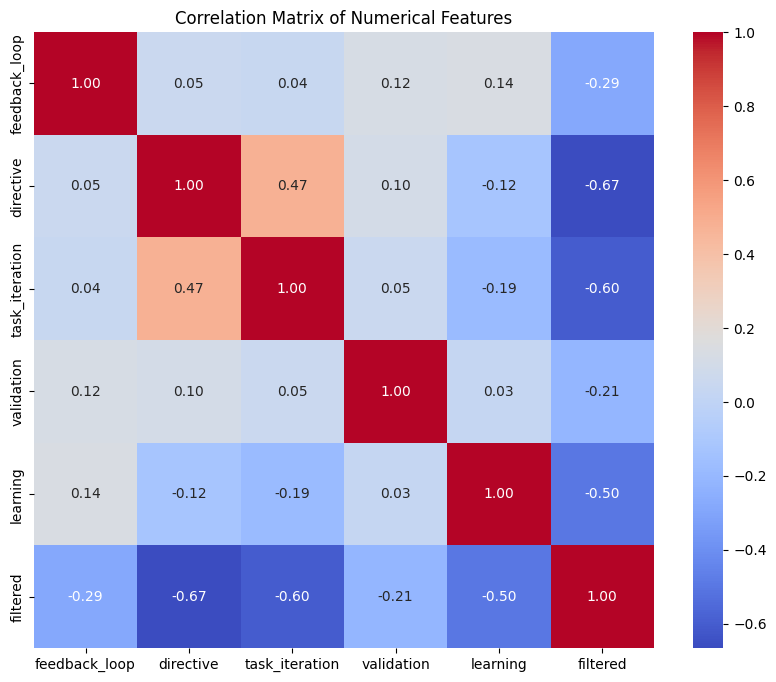

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Phase 2: Text Analysis of `task_name`

The `task_name` column contains rich textual information. Analyzing this text can reveal key themes and common terminology used to describe AI tasks.

### 2.1. Word Cloud

A word cloud provides a quick visual summary of the most frequent words in the task descriptions. The larger the word, the more often it appears.

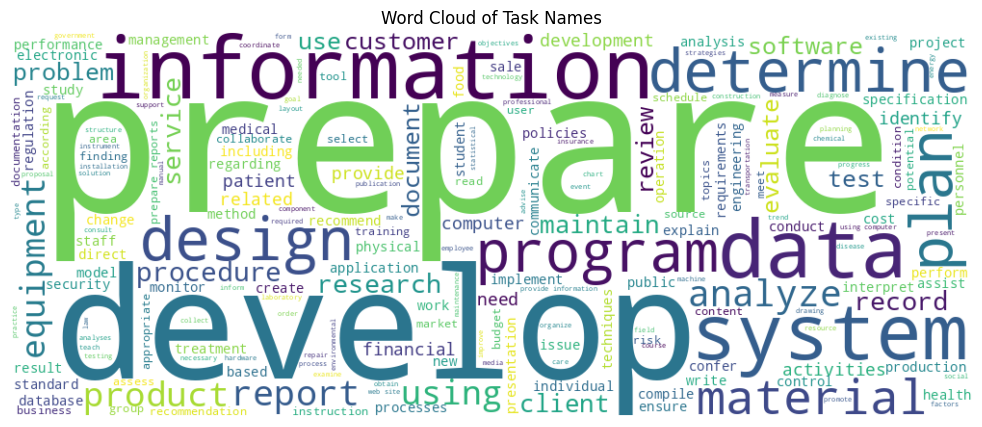

In [18]:
# Text Analysis of task_name
text = ' '.join(df['task_name'].dropna())
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(text)

plt.figure(figsize=(25, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Task Names')
plt.show()

### 2.2. N-gram Analysis

While word clouds show individual words, n-grams help us identify common multi-word phrases. We will look at unigrams (single words) and bigrams (two-word phrases) to get a better sense of the common terminology.

In [6]:
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = TfidfVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_unigrams = get_top_ngrams(df['task_name'].dropna(), n=20, ngram_range=(1, 1))
top_bigrams = get_top_ngrams(df['task_name'].dropna(), n=20, ngram_range=(2, 2))

print('Top 20 Unigrams:')
print(top_unigrams)

print('Top 20 Bigrams:')
print(top_bigrams)

Top 20 Unigrams:
[('prepare', np.float64(68.82974179193569)), ('information', np.float64(64.23670282839467)), ('develop', np.float64(61.581028892374775)), ('data', np.float64(56.69666931169057)), ('reports', np.float64(53.5592143670767)), ('provide', np.float64(46.848188998915745)), ('research', np.float64(44.95598268090992)), ('determine', np.float64(43.11553207653221)), ('analyze', np.float64(42.87473013344226)), ('systems', np.float64(42.49527364310017)), ('using', np.float64(41.0672308544438)), ('design', np.float64(39.68585298946802)), ('materials', np.float64(37.48268345995571)), ('equipment', np.float64(37.216692390542505)), ('procedures', np.float64(37.14081212885443)), ('maintain', np.float64(35.5163736158878)), ('programs', np.float64(35.33391746819577)), ('software', np.float64(34.72702650393224)), ('problems', np.float64(31.755738289746606)), ('evaluate', np.float64(31.540815620453014))]
Top 20 Bigrams:
[('prepare reports', np.float64(11.825619597795221)), ('provide informa

## Phase 3: Unsupervised Learning - Clustering

Now we move to machine learning. Our first goal is to see if we can find natural groupings or 'clusters' of tasks based on their numerical features. This is an unsupervised learning problem because we don't have pre-defined labels for the task types.

### 3.1. Feature Scaling and Finding Optimal Clusters

K-Means is sensitive to the scale of features, so we first scale our data using `StandardScaler`. Then, we use the 'Elbow Method' to find the optimal number of clusters (k). The 'elbow' in the plot of inertia vs. number of clusters suggests the best value for k.

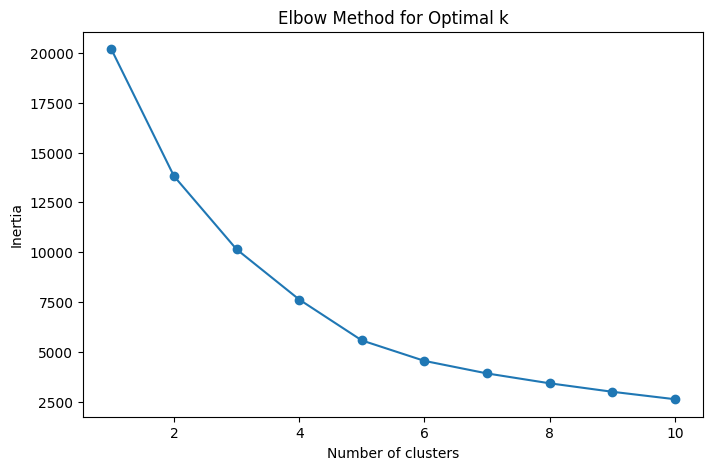

In [7]:
# Unsupervised Learning - Clustering
features = df[numerical_features].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow method to find optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### 3.2. K-Means Clustering and Visualization

Based on the elbow plot, we select the optimal k and run the K-Means algorithm. To visualize the clusters, we use Principal Component Analysis (PCA) to reduce the 6-dimensional feature space to 2 dimensions. This allows us to plot the clusters on a scatter plot.

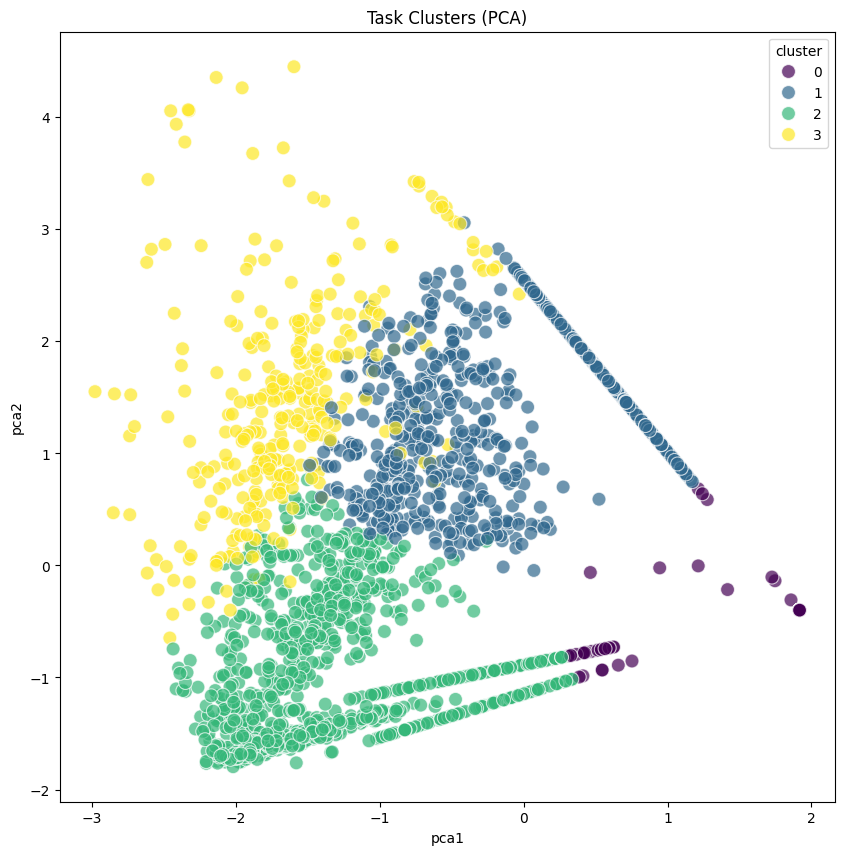

In [8]:
# K-Means Clustering
optimal_k = 4 # We'll choose 4 based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clustered = df.dropna(subset=numerical_features).copy()
df_clustered.loc[:, 'cluster'] = kmeans.fit_predict(scaled_features)

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df_clustered.loc[:, 'pca1'] = principal_components[:, 0]
df_clustered.loc[:, 'pca2'] = principal_components[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df_clustered, palette='viridis', s=100, alpha=0.7)
plt.title('Task Clusters (PCA)')
plt.show()

## Phase 4: Supervised Learning - Task Classification

Now that we have assigned a cluster label to each task, we can treat this as a supervised learning problem. The goal is to train a model that can predict the cluster (task type) for a new task based only on its `task_name`.

### 4.1. Feature Engineering and Model Training

We need to convert the text in `task_name` into a numerical format that a machine learning model can understand. We use `TfidfVectorizer` for this, which represents each task name as a vector of TF-IDF scores. We then train a Multinomial Naive Bayes model, a classic and effective algorithm for text classification.

In [9]:
# Supervised Learning - Task Classification
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_clustered['task_name'])
y = df_clustered['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### 4.2. Model Evaluation

Finally, we evaluate our model's performance. We'll look at:
- **Accuracy:** The overall percentage of correct predictions.
- **Classification Report:** This provides precision, recall, and F1-score for each class, giving a more nuanced view of the performance.
- **Confusion Matrix:** A visual representation of the model's predictions vs. the actual labels, showing where the model is getting confused.

Accuracy: 0.5066864784546805
Classification Report:               precision    recall  f1-score   support

           0       0.41      0.50      0.45       224
           1       0.66      0.41      0.51       165
           2       0.54      0.72      0.62       223
           3       0.00      0.00      0.00        61

    accuracy                           0.51       673
   macro avg       0.40      0.41      0.39       673
weighted avg       0.48      0.51      0.48       673



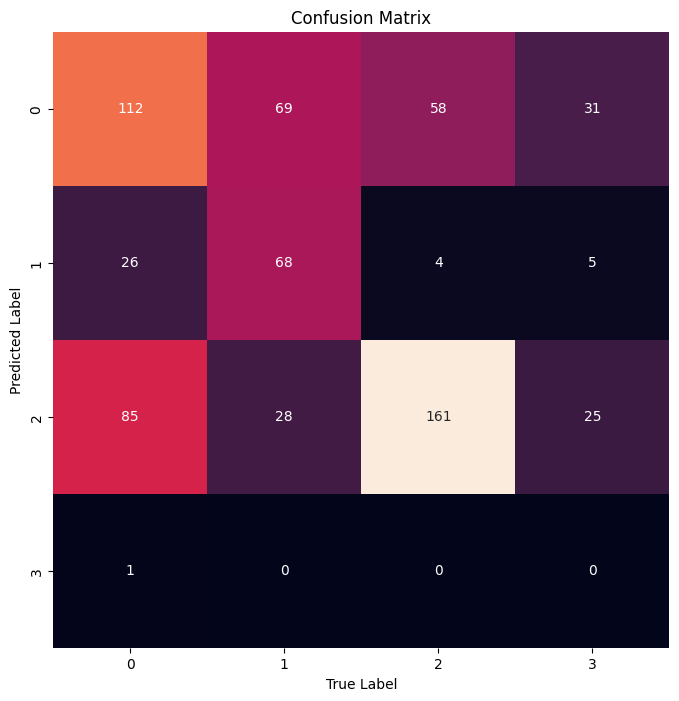

In [16]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))

# Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()